In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from dataset import FlyPlumeDataset
from snn_controller import PlumetrackingSNN  #SNN model class
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pickle


# Load processed dataset
df = pd.read_csv("processed_fly_data.csv")

# Initialize dataset and dataloader
dataset = FlyPlumeDataset(df)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=6, pin_memory=True)

# penalize the model from just guessing the overrepresented class, stop.
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df["label"]),
    y=df["label"]
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Initialize model, loss, optimizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PlumetrackingSNN().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_accuracy = 0.0
all_losses = []
all_accuracies = []


# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    for inputs, labels, fly_ids in tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=False):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()
        # Compute accuracy
        preds = torch.argmax(outputs.detach(), dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    accuracy = 100.0 * total_correct / total_samples
    torch.cuda.empty_cache()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

    all_losses.append(total_loss)
    all_accuracies.append(accuracy)

    # After epoch:
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    print(classification_report(all_labels, all_preds, target_names=["FORWARD", "LEFT", "RIGHT", "STOP"],zero_division=0))
    print("Sample predictions:", preds[:10].cpu().numpy())
    print("Ground truth:", labels[:10].cpu().numpy())

    # Save best model so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "best_model.pt")
        print(f"✅ Best model saved (Epoch {epoch+1}, Accuracy: {accuracy:.2f}%)")

# Save final model
torch.save(model.state_dict(), "final_model.pt")
print("🧠 Final model saved as final_model.pt")

# Save training stats
training_stats = {
    "losses": all_losses,
    "accuracies": all_accuracies
}
with open("training_stats.pkl", "wb") as f:
    pickle.dump(training_stats, f)
print("📊 Training stats saved to training_stats.pkl")


Epoch 1:   0%|          | 0/33 [00:00<?, ?it/s]

Raw output sample (spike counts): [[-1.3862944 -1.3862944 -1.3862944 -1.3862944]
 [-1.3862944 -1.3862944 -1.3862944 -1.3862944]
 [-1.3862944 -1.3862944 -1.3862944 -1.3862944]
 [-1.3862944 -1.3862944 -1.3862944 -1.3862944]
 [-1.3862944 -1.3862944 -1.3862944 -1.3862944]]
Labels: [3 3 0 3 0]


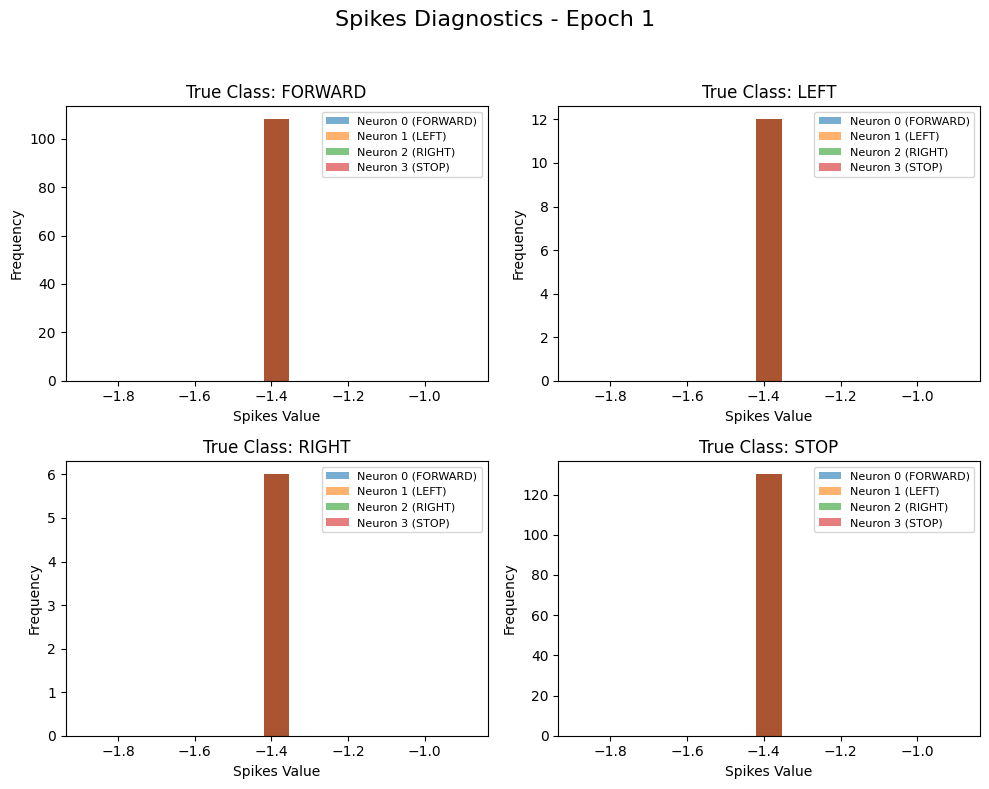

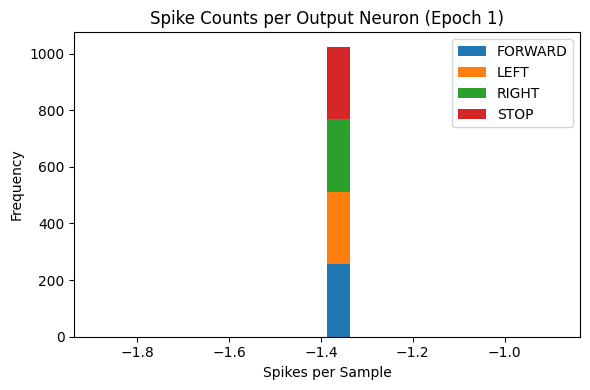

Epoch 1, Loss: 45.7477, Accuracy: 38.08%
Avg spike count per sample: 0.00
              precision    recall  f1-score   support

     FORWARD       0.38      1.00      0.55      3126
        LEFT       0.00      0.00      0.00       189
       RIGHT       0.00      0.00      0.00       210
        STOP       0.00      0.00      0.00      4683

    accuracy                           0.38      8208
   macro avg       0.10      0.25      0.14      8208
weighted avg       0.15      0.38      0.21      8208

Sample predictions: [0 0 0 0 0 0 0 0 0 0]
Ground truth: [3 0 2 3 2 3 0 3 0 3]


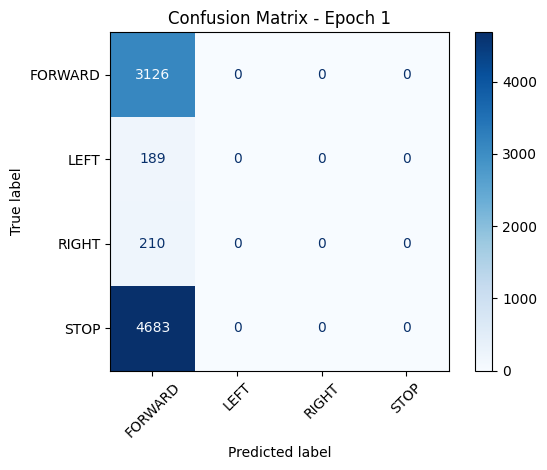

Epoch 2:   0%|          | 0/33 [00:00<?, ?it/s]

Raw output sample (spike counts): [[-1.3862944 -1.3862944 -1.3862944 -1.3862944]
 [-1.3862944 -1.3862944 -1.3862944 -1.3862944]
 [-1.3862944 -1.3862944 -1.3862944 -1.3862944]
 [-1.3862944 -1.3862944 -1.3862944 -1.3862944]
 [-1.3862944 -1.3862944 -1.3862944 -1.3862944]]
Labels: [3 3 0 3 0]


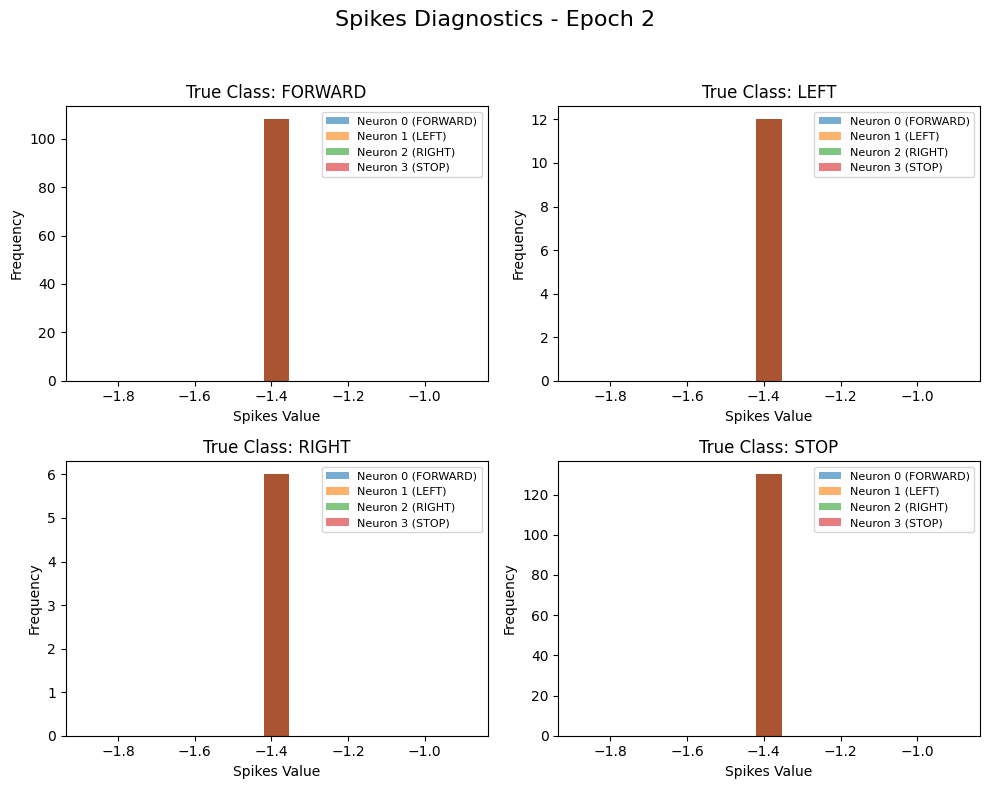

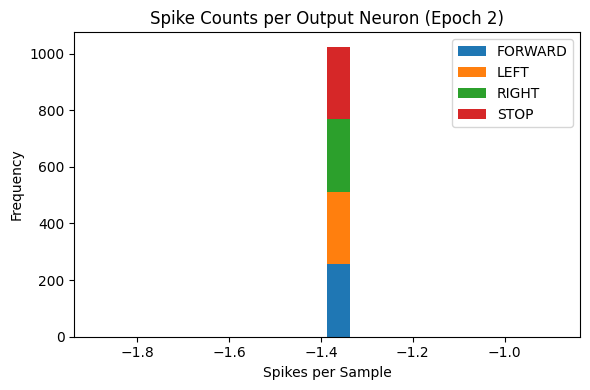

Epoch 2, Loss: 45.7477, Accuracy: 38.08%
Avg spike count per sample: 0.00
              precision    recall  f1-score   support

     FORWARD       0.38      1.00      0.55      3126
        LEFT       0.00      0.00      0.00       189
       RIGHT       0.00      0.00      0.00       210
        STOP       0.00      0.00      0.00      4683

    accuracy                           0.38      8208
   macro avg       0.10      0.25      0.14      8208
weighted avg       0.15      0.38      0.21      8208

Sample predictions: [0 0 0 0 0 0 0 0 0 0]
Ground truth: [3 0 2 3 2 3 0 3 0 3]


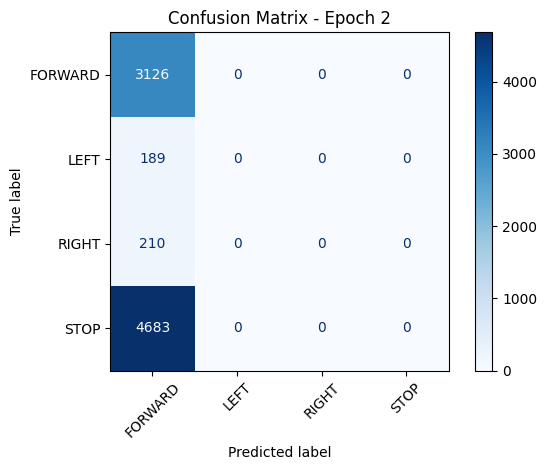

Epoch 3:   0%|          | 0/33 [00:00<?, ?it/s]

Raw output sample (spike counts): [[-1.3862944 -1.3862944 -1.3862944 -1.3862944]
 [-1.3862944 -1.3862944 -1.3862944 -1.3862944]
 [-1.3862944 -1.3862944 -1.3862944 -1.3862944]
 [-1.3862944 -1.3862944 -1.3862944 -1.3862944]
 [-1.3862944 -1.3862944 -1.3862944 -1.3862944]]
Labels: [3 3 0 3 0]


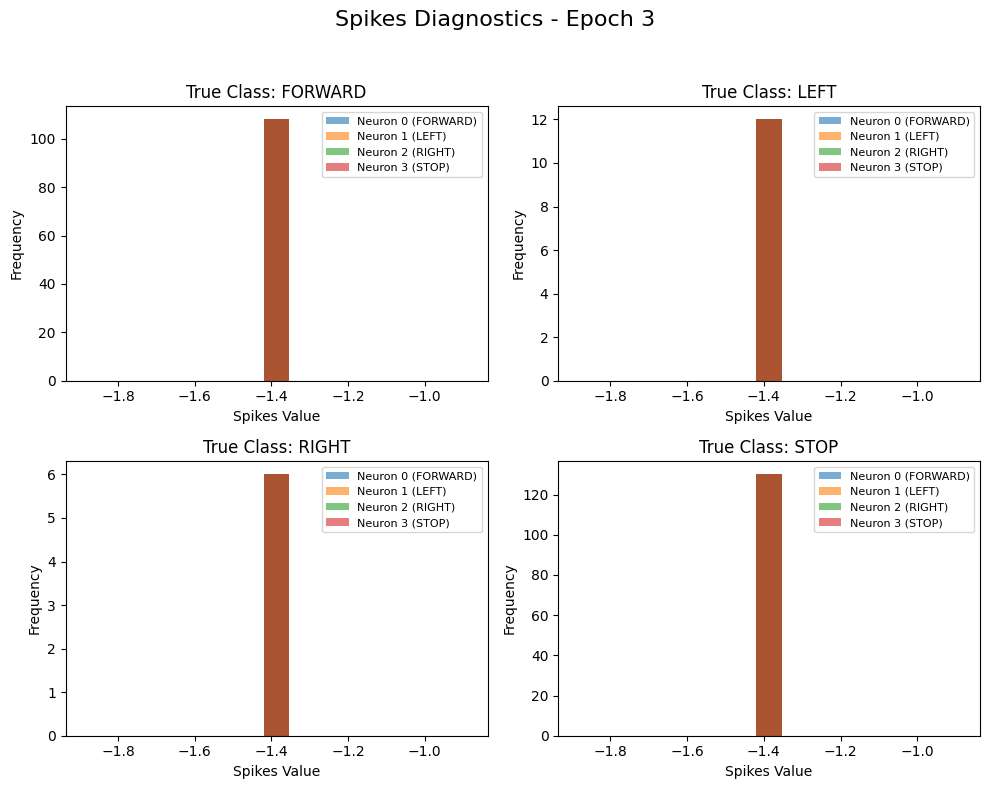

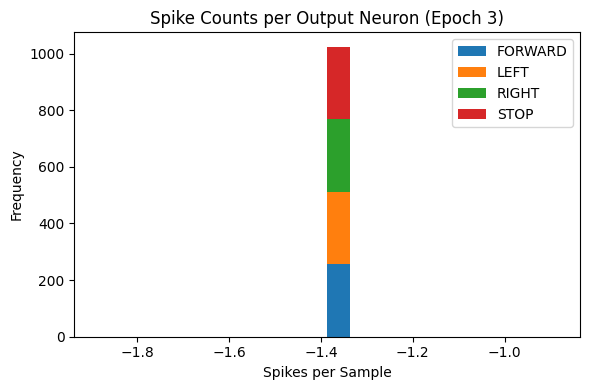

KeyboardInterrupt: 

In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from dataset import FlyPlumeDataset
from snn_controller import PlumetrackingSNN, SNNPlumeController  #SNN model class
from tqdm import tqdm
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

def plot_diagnostics(log_probs, labels, epoch, mode="spikes"):
    """outputs: [batch, 4] spike counts or mem
       labels:  [batch]
    """
    log_probs = log_probs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    class_names = ["FORWARD", "LEFT", "RIGHT", "STOP"]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle(f"{mode.capitalize()} Diagnostics - Epoch {epoch+1}", fontsize=16)

    for i, ax in enumerate(axes.flat):
        label_mask = labels == i
        if np.sum(label_mask) == 0:
            continue

        for j in range(4):
            ax.hist(
                log_probs[label_mask, j],
                bins=15,
                alpha=0.6,
                label=f"Neuron {j} ({class_names[j]})",
                color=colors[j],
            )
        ax.set_title(f"True Class: {class_names[i]}")
        ax.set_xlabel(f"{mode.capitalize()} Value")
        ax.set_ylabel("Frequency")
        ax.legend(fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Load processed dataset
df = pd.read_csv("processed_fly_data.csv").sample(n=10000, random_state=42).reset_index(drop=True)

# Initialize dataset and dataloader
dataset = FlyPlumeDataset(df,shuffle_trajs=True)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

# penalize the model from just guessing the overrepresented class, stop.
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df["label"]),
    y=df["label"]
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Initialize model, loss, optimizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PlumetrackingSNN().to(device)
controller = SNNPlumeController(model, timestep=112, device="cuda")
#criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
criterion = nn.NLLLoss(weight=class_weights_tensor.to(device))
optimizer = optim.Adam(model.parameters(), lr=4e-3)
entropy_weight = 0.01
best_accuracy = 0.0
all_losses = []
all_accuracies = []


# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    for batch_idx, (inputs, labels, fly_ids) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=False)):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        spike_counts, spk4_stack = model(inputs)
        log_probs = torch.log_softmax(spike_counts, dim=1)



        if batch_idx == 0:
            print("Raw output sample (spike counts):", log_probs[:5].detach().cpu().numpy())
            print("Labels:", labels[:5].cpu().numpy())

        
        # Main loss
        # ce_loss = criterion(log_probs, labels)
        # # Entropy regularization (encourage confident choices)
        # probs = torch.exp(log_probs)
        # entropy = - (probs * log_probs).sum(dim=1).mean()
        # competition_loss = ((probs.sum(dim=1) - 1)**2).mean()
        # loss = ce_loss + 0.05* entropy +0.05 * competition_loss # play with this weight



        #competition_loss = (log_probs.exp().sum(dim=1) - 1).pow(2).mean()
        #loss = criterion(log_probs, labels) + 1e-2 * competition_loss


        loss = criterion(log_probs, labels)
#        outputs, spk4 = model(inputs)
#        ce_loss = criterion(outputs, labels)
#        spike_counts = spk4.sum(dim=1)  # [batch_size], number of spikes per sample
#        avg_spike_count = spike_counts.mean()
#        spike_reg = avg_spike_count  # use this for regularization
#        loss = ce_loss + 1e-5 * spike_reg  # 1e-3 is a good starting weight

        loss.backward()
        optimizer.step()

        # Accuracy
        preds = torch.argmax(log_probs.detach(), dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())
        total_loss += loss.item()

        if batch_idx == 0:
            plot_diagnostics(log_probs, labels, epoch, mode="spikes")

            plt.figure(figsize=(6, 4))
            plt.hist(log_probs.detach().cpu().numpy(), bins=20, stacked=True, label=["FORWARD", "LEFT", "RIGHT", "STOP"])
            plt.title(f"Spike Counts per Output Neuron (Epoch {epoch+1})")
            plt.xlabel("Spikes per Sample")
            plt.ylabel("Frequency")
            plt.legend()
            plt.tight_layout()
            plt.show()


    accuracy = 100.0 * total_correct / total_samples
    torch.cuda.empty_cache()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")
    # Average spikes per neuron per sample across all timesteps
    avg_spike_count = spk4_stack.sum(dim=1).mean()  # [batch, timesteps, 4] → [batch, 4] → mean
    print(f"Avg spike count per sample: {avg_spike_count.item():.2f}")



    all_losses.append(total_loss)
    all_accuracies.append(accuracy)
    label_ids = [0, 1, 2, 3]
    # After epoch:
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    print(classification_report(all_labels, all_preds, labels=label_ids, target_names=["FORWARD", "LEFT", "RIGHT", "STOP"],zero_division=0))
    print("Sample predictions:", preds[:10].cpu().numpy())
    print("Ground truth:", labels[:10].cpu().numpy())
    for name, param in model.named_parameters():
        if "readout" in name:
            print(name, param.data.norm())


    cm = confusion_matrix(all_labels, all_preds,labels=label_ids)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FORWARD", "LEFT", "RIGHT", "STOP"])
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"Confusion Matrix - Epoch {epoch+1}")
    plt.tight_layout()
    plt.show()

# Save training stats
training_stats = {
    "losses": all_losses,
    "accuracies": all_accuracies
}
with open("sample training_stats.pkl", "wb") as f:
    pickle.dump(training_stats, f)
print("sample training stats saved to training_stats.pkl")

In [ ]:
criterion = nn.CrossEntropyLoss()
test_input = torch.tensor([[100.0, 0.0, 0.0, 0.0]])
test_label = torch.tensor([0])
print("Loss on test:", criterion(test_input, test_label).item())


In [ ]:
criterion = nn.CrossEntropyLoss()
test_input = torch.tensor([[100.0, 0.0, 0.0, 0.0]])
test_label = torch.tensor([0])
print("Loss on test:", criterion(test_input, test_label).item())


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from snn_controller import PlumetrackingSNN  # Make sure it's updated!
from dataset import FlyPlumeDataset
import pandas as pd

# Load the dataset
df = pd.read_csv("processed_fly_data.csv")
dataset = FlyPlumeDataset(df)

# Just take one batch
batch_size = 512
inputs, labels, _ = zip(*[dataset[i] for i in range(batch_size)])
inputs = torch.stack(inputs)
labels = torch.tensor(labels)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = inputs.to(device)
labels = labels.to(device)

# Initialize model, loss, optimizer
model = PlumetrackingSNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)

# Train on same batch multiple times
for step in range(20):
    model.train()
    optimizer.zero_grad()
    outputs = model(inputs)

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Accuracy
    preds = torch.argmax(outputs, dim=1)
    acc = (preds == labels).float().mean().item()

    print(f"Step {step}: Loss = {loss.item():.4f}, Accuracy = {acc:.2f}")


In [ ]:
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

# Setup
batch_size = 512
start_lr = 1e-5
end_lr = 1e-1
num_batches = 200  # Stop after this many batches to keep things fast
mult = (end_lr / start_lr) ** (1 / num_batches)

model = PlumetrackingSNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=start_lr)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

model.train()
lrs = []
losses = []
lr = start_lr

progress_bar = tqdm(enumerate(dataloader), total=num_batches, desc="LR Range Test")

for batch_idx, (inputs, labels, fly_ids) in progress_bar:
    if batch_idx >= num_batches:
        break

    inputs = inputs.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)

    optimizer.zero_grad()
    outputs = model(inputs)

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Log (detach to prevent memory buildup)
    lrs.append(lr)
    losses.append(loss.item())

    progress_bar.set_postfix(lr=lr, loss=loss.item())


    # Update LR
    lr *= mult
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

        # Clear computation graph to save memory
    
    torch.cuda.empty_cache()
    
    if math.isnan(loss.item()) or loss.item() > 10:
        print("Loss diverged — stopping early.")
        break
    
    del outputs, loss


# Plot loss vs learning rate
plt.figure(figsize=(8, 5))
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Loss")
plt.title("Learning Rate Range Test")
plt.grid(True)
plt.show()


In [ ]:
import pickle

with open("training_stats.pkl", "rb") as f:
    stats = pickle.load(f)

# Check what keys are stored
print(stats.keys())  # e.g., ['epoch_losses', 'epoch_accuracies']

# Example plot of accuracy
import matplotlib.pyplot as plt

plt.plot(stats["accuracies"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy over Epochs")
plt.grid(True)
plt.show()

# Same for loss
plt.plot(stats["losses"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()

